# Potato Disease Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import all the Dependencies

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 227
CHANNELS=3
EPOCHS=50

In [ ]:
IMAGE_SIZE = 227
BATCH_SIZE = 32
shuffle=True
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/modling workshop/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 227, 227, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]



As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualization of dataset

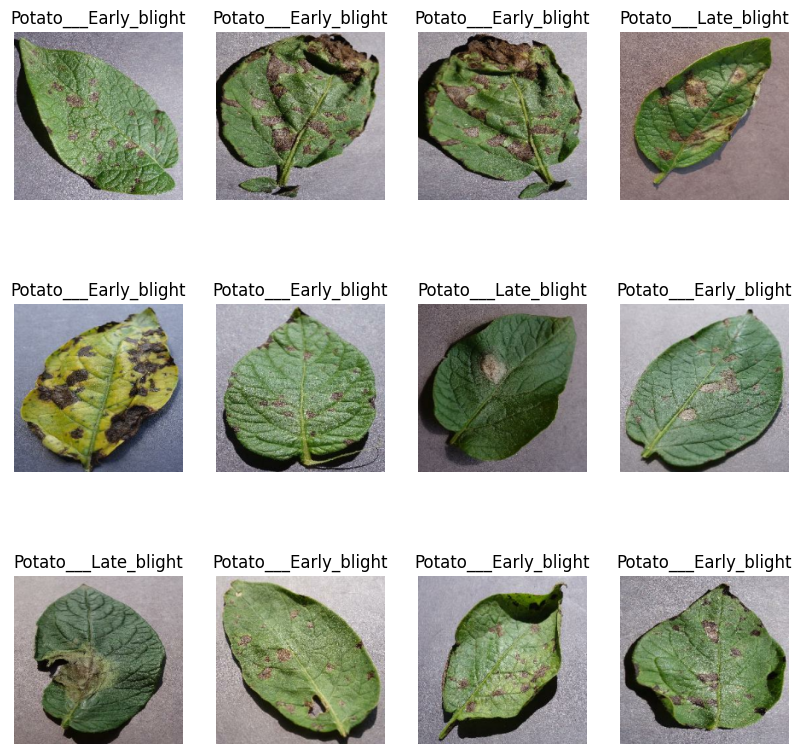

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,  
                         
                          
                          4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset
prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



## AlexNet Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
# Define the model
model = keras.Sequential(
    [
        layers.Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),
        layers.Conv2D(256, (5,5), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),
        layers.Conv2D(384, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3,3), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(5, activation='softmax')
    ]
)


model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
import time

In [ ]:
%%time
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 75s 312ms/step - loss: 10.3932 - accuracy: 0.6782 - val_loss: 129.3251 - val_accuracy: 0.4427
Epoch 2/50
54/54 [==============================] - 13s 239ms/step - loss: 2.0465 - accuracy: 0.7743 - val_loss: 73.7504 - val_accuracy: 0.4479
Epoch 3/50
54/54 [==============================] - 13s 238ms/step - loss: 1.1764 - accuracy: 0.7946 - val_loss: 13.9455 - val_accuracy: 0.5365
Epoch 4/50
54/54 [==============================] - 14s 267ms/step - loss: 0.9415 - accuracy: 0.8270 - val_loss: 17.3509 - val_accuracy: 0.5260
Epoch 5/50
54/54 [==============================] - 13s 237ms/step - loss: 0.7352 - accuracy: 0.8466 - val_loss: 16.5602 - val_accuracy: 0.7969
Epoch 6/50
54/54 [==============================] - 13s 233ms/step - loss: 0.7467 - accuracy: 0.8640 - val_loss: 47.0588 - val_accuracy: 0.6823
Epoch 7/50
54/54 [==============================] - 14s 252ms/step - loss: 0.6137 - accuracy: 0.8657 - val_loss: 14.1603 - val_accurac

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 28ms/step - loss: 5.3977 - accuracy: 0.6211


**You can see above that we get 62.11 % accuracy for our test dataset. This is considered to be not a good acuracy**

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
df = pd.DataFrame(history.history['loss']  , columns = ['Training_loss'])
df.head()

,Training_loss
0,10.393170
1,2.046460
2,1.176426
3,0.941522
4,0.735207


In [ ]:
df['Training_acc'] = history.history['accuracy']

In [ ]:
df['val_loss'] = history.history['val_loss']

In [ ]:
df['val_accuracy'] = history.history['val_accuracy']

In [ ]:
df.head(2)

,Training_loss,Training_acc,val_loss,val_accuracy
0,10.39317,0.678241,129.325150,0.442708
1,2.04646,0.774306,73.750435,0.447917


In [ ]:
df.to_csv('Final_result_Alexnet.csv')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

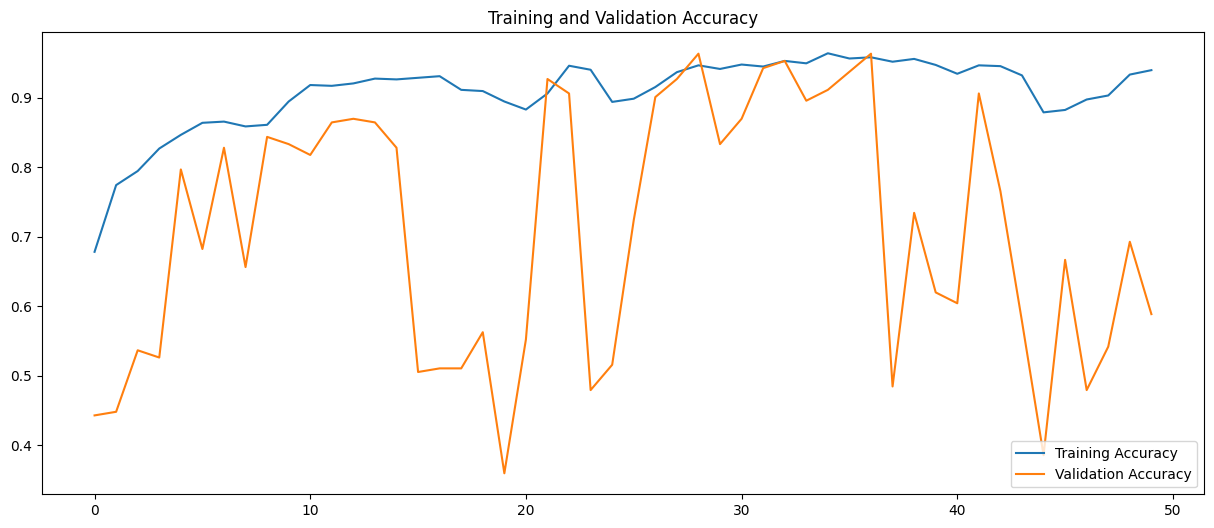

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('graph_1.pdf')

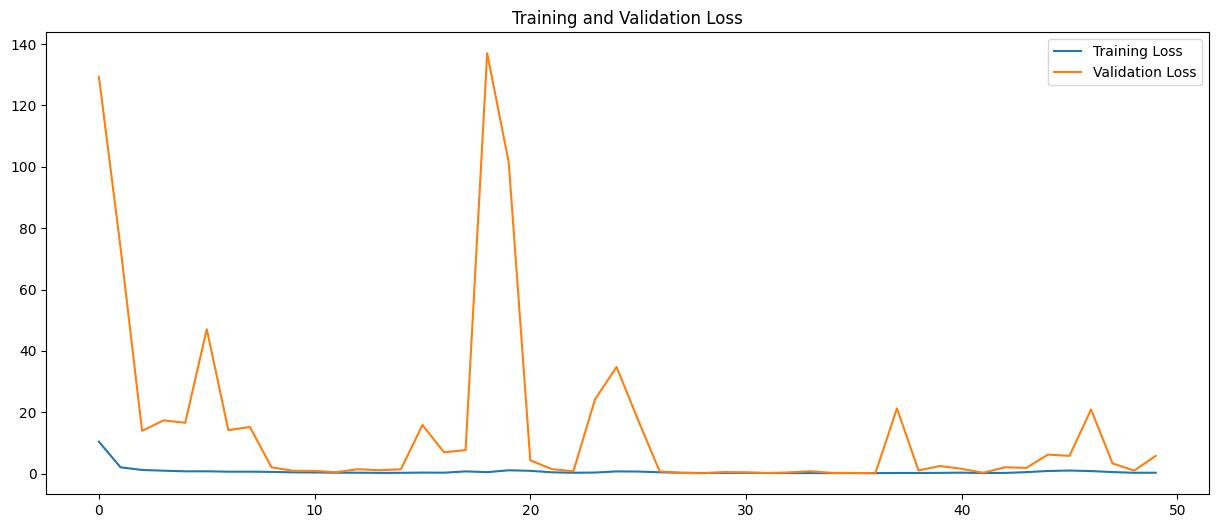

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('graph_2.pdf')
plt.show()


### Run prediction on a sample image

actual label: Potato___Late_blight
1/1 [==============================] - 0s 47ms/step
predicted label: Potato___Early_blight


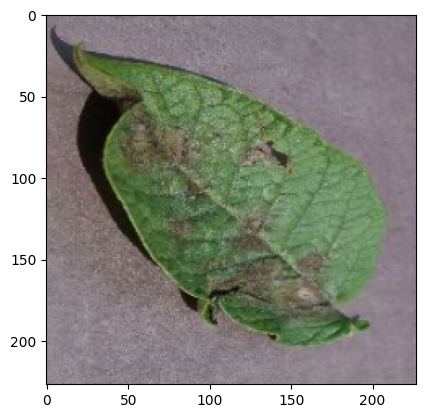

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 23ms/step


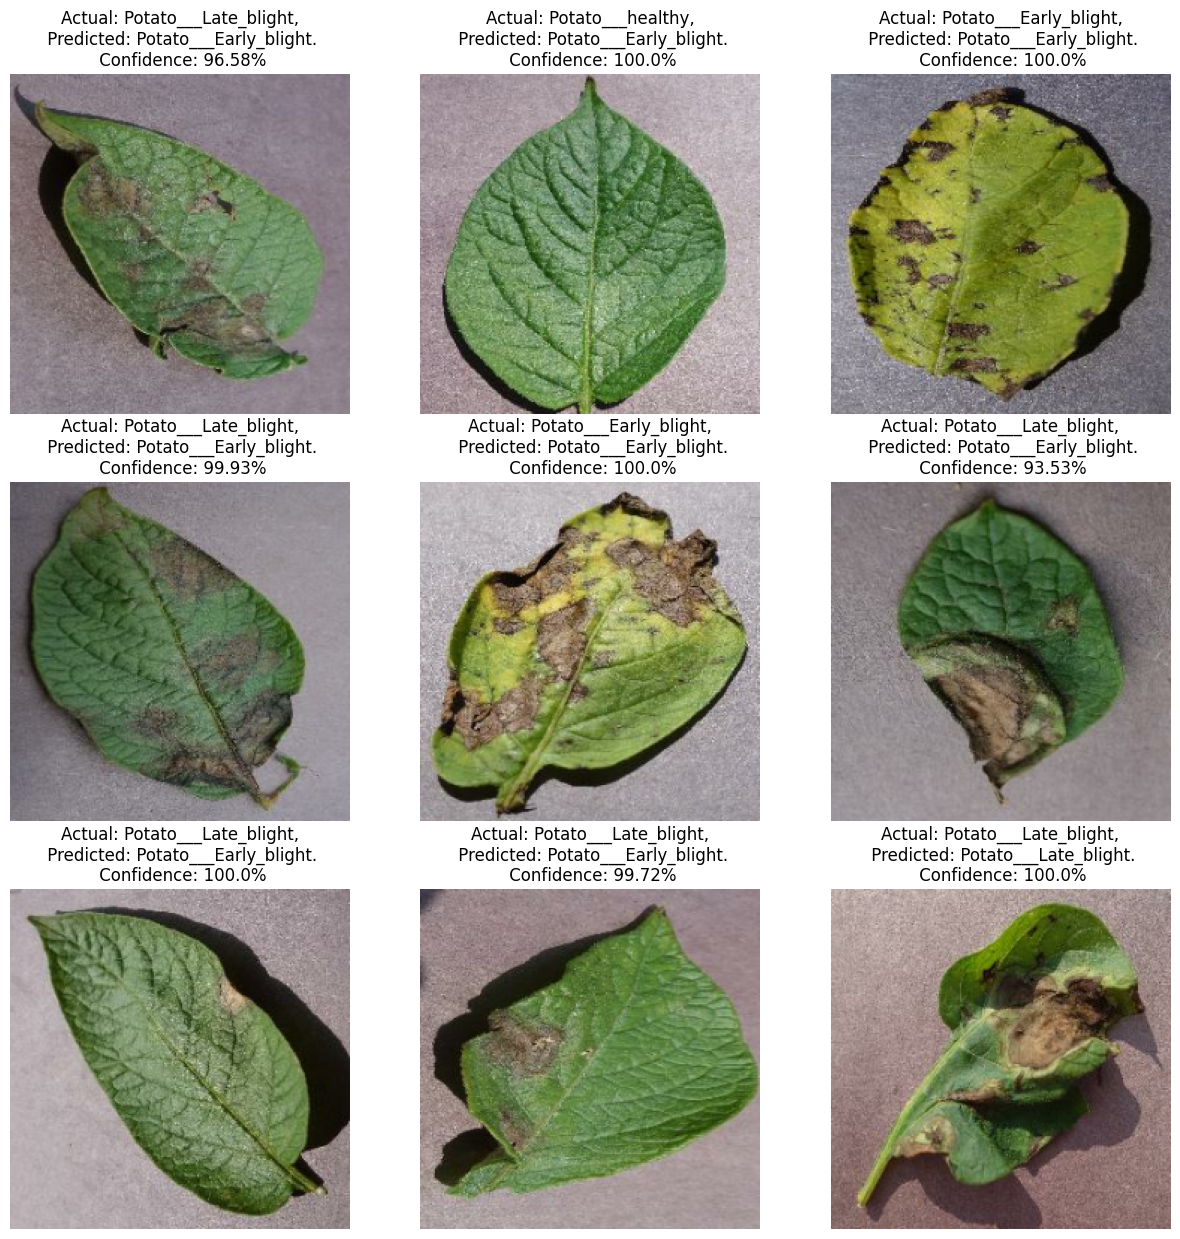

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.savefig('result.pdf')
        plt.axis("off")